In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Informasi Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

In [ ]:
# Folder yang berisi dataset dari 88 user
dataset_folder = '/content/drive/MyDrive/KULIAH/feature_kmt_xlsx'

In [ ]:
def extract_number(filename):
    # Mencari angka pertama yang ada dalam nama file menggunakan regular expression
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

# Mengatur opsi pandas untuk menampilkan seluruh baris
pd.set_option('display.max_rows', None)  # None berarti tidak ada batas
pd.set_option('display.max_columns', None)  # Menampilkan semua kolom
pd.set_option('display.width', None)  # Mengatur lebar tampilan ke lebar layar

# Membuat daftar file yang berakhiran ".xlsx" di folder dataset
files = [f for f in os.listdir(dataset_folder) if f.endswith(".xlsx")]
# Mengurutkan file berdasarkan angka yang ditemukan di dalam nama file
sorted_files = sorted(files, key=extract_number)

# Iterasi melalui setiap file yang sudah diurutkan
for filename in sorted_files:
    # Menyusun path lengkap dari file
    filepath = os.path.join(dataset_folder, filename)
    try:
        # Membaca file Excel dan menyimpannya ke dalam DataFrame
        df = pd.read_excel(filepath)
        print(f"\nDataset for {filename}:")

        # Menghapus kolom yang mengandung "Unnamed" jika ada
        unnamed_columns = [col for col in df.columns if 'Unnamed' in col]
        if unnamed_columns:
            df.drop(columns=unnamed_columns, inplace=True)
            print(f"Unnamed columns {unnamed_columns} dropped.")

        # Menampilkan seluruh data dari DataFrame
        print("\nFull dataset:")
        print(df)  # Menampilkan seluruh baris dan kolom

        # Cek jumlah missing values (nilai yang hilang) di dalam dataset
        missing_values_count = df.isnull().sum().sum()
        print(f"\nTotal missing values in the dataset: {missing_values_count}")

        # Menampilkan statistik deskriptif dari dataset
        print("\nDescriptive statistics:")
        print(df.describe(include='all'))

        # # Membuat pair plot untuk kolom numerik
        # numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
        # if len(numeric_columns) > 1:
        #     plt.figure(figsize=(12, 8))
        #     sns.pairplot(df[numeric_columns])
        #     plt.suptitle(f'Pair Plot for {filename}', y=1.02)
        #     plt.show()

        # Menambahkan garis pemisah antar file yang diproses
        print("-" * 50)

    except Exception as e:
        print(f"Error processing {filename}: {e}")


Dataset for feature_kmt_user_0001.xlsx:
Unnamed columns ['Unnamed: 0'] dropped.

Full dataset:
    dwell_avg  flight_avg    traj_avg  label
0    0.093341    0.364395  681.614430      1
1    0.085055    0.355090  596.133007      1
2    0.091337    0.428217  663.518174      1
3    0.091395    0.306243  580.373215      1
4    0.087598    0.401027  614.361149      1
5    0.091835    0.358024  681.028155      1
6    0.087437    0.317831  664.862424      1
7    0.097054    0.330271  493.698698      1
8    0.091275    0.401341  579.457447      1
9    0.095933    0.361527  500.615889      1
10   0.090275    0.521462  516.003409      0
11   0.100985    0.833044  412.547653      0
12   0.073261    0.687610  663.611959      0
13   0.130867    0.897945  290.198244      0
14   0.179208    0.670023  345.483451      0
15   0.100080    0.849405  273.365884      0
16   0.126100    0.247867  401.456842      0
17   0.076832    0.466030  310.198292      0
18   0.067409    0.853341  409.943210      0
19  

# EER, FMR, FNMR, MISSCLASSIFICATION CHECK

## FMR & FNMR

In [ ]:
def calculate_fmr_fnmr(tp, fp, fn, tn):
    # Menghitung False Match Rate (FMR)
    # FMR dihitung dengan membagi jumlah false positive (fp) dengan jumlah seluruh negatif (fp + tn)
    # Jika jumlah fp + tn sama dengan 0, maka FMR diatur menjadi 0 untuk menghindari pembagian dengan 0
    fmr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Match Rate

    # Menghitung False Non-Match Rate (FNMR)
    # FNMR dihitung dengan membagi jumlah false negative (fn) dengan jumlah seluruh positif (fn + tp)
    # Jika jumlah fn + tp sama dengan 0, maka FNMR diatur menjadi 0 untuk menghindari pembagian dengan 0
    fnmr = fn / (fn + tp) if (fn + tp) != 0 else 0  # False Non-Match Rate

    # Mengembalikan nilai FMR dan FNMR yang telah dihitung
    return fmr, fnmr


## EER

In [ ]:
def calculate_eer(fmr, fnmr):
    # Menghitung Equal Error Rate (EER) dengan mengambil rata-rata antara False Match Rate (FMR) dan False Non-Match Rate (FNMR)
    eer = (fmr + fnmr) / 2  # EER adalah rata-rata dari FMR dan FNMR

    # Mengembalikan nilai EER yang telah dihitung
    return eer


## MISSCLASSIFICATION CHECK

In [ ]:
# Fungsi untuk memeriksa misclassifications (kesalahan klasifikasi)
def check_misclassifications(X_test, y_test, y_pred):
    # Mengambil data yang terklasifikasi salah, yaitu data yang label sebenarnya (y_test) tidak sama dengan label yang diprediksi (y_pred)
    misclassified = X_test[y_test != y_pred].copy()

    # Menambahkan kolom 'True Label' yang berisi label sebenarnya dari data yang terklasifikasi salah
    misclassified.loc[:, 'True Label'] = y_test[y_test != y_pred].values

    # Menambahkan kolom 'Predicted Label' yang berisi label yang diprediksi dari data yang terklasifikasi salah
    misclassified.loc[:, 'Predicted Label'] = y_pred[y_test != y_pred]

    # Mengembalikan dataframe yang berisi data yang terklasifikasi salah beserta label sebenarnya dan label yang diprediksi
    return misclassified


# Diffprivlib

## Install Diffprivlib

In [ ]:
pip install diffprivlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 9.5 MB/s eta 0:00:00


## Sensitivity

In [ ]:
# Fungsi untuk menghitung sensitivitas
def calculate_sensitivity(X_train):
    return np.max(np.abs(X_train.max(axis=0) - X_train.min(axis=0)))

## Library

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import  plot_tree
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from diffprivlib.utils import PrivacyLeakWarning
from diffprivlib.accountant import BudgetAccountant
from diffprivlib.mechanisms import GaussianAnalytic
from numpy import random
import warnings
warnings.filterwarnings("ignore", category=PrivacyLeakWarning)  # Mengabaikan peringatan kebocoran privasi

## Bounds

In [ ]:
def calculate_bounds(df):
    numeric_cols = df.select_dtypes(include=['number'])

    if not numeric_cols.empty:
        min_values = numeric_cols.min().values  # Get min values for all columns as an array
        max_values = numeric_cols.max().values  # Get max values for all columns as an array
        return (min_values, max_values)  # Return as a tuple
    else:
        return ([], [])  # Return empty tuple if no numeric columns

# Decision Tree with Differential Privacy

In [ ]:
# Function to add Gaussian noise to features with consistent results
def add_gaussian_noise(data, epsilon, delta, sensitivity, random_state, budget_accountant):
    # Set seed for reproducibility

    mechanism = GaussianAnalytic(epsilon=epsilon, delta=delta, sensitivity=sensitivity, random_state=random_state)

    # Menambahkan noise ke setiap kolom fitur
    data_noisy = data.copy()
    for column in data_noisy.columns:
        # Menambahkan noise Gaussian ke setiap fitur
        data_noisy[column] = data_noisy[column].apply(lambda x: mechanism.randomise(x))

    # Update the budget after adding noise
    budget_accountant.spend(epsilon, delta=delta)

    return data_noisy

In [ ]:
# Fungsi untuk melatih dan mengevaluasi model dengan Differential Privacy
def train_and_evaluate_dp(file_path, epsilon):
    # Load dataset
    data = pd.read_excel(file_path)  # Assuming data is in Excel format

    # Memisahkan fitur dan label
    X = data[['dwell_avg', 'flight_avg', 'traj_avg']]  # Fitur yang diekstraksi
    y = data['label']  # Label: 1 = legitimate, 0 = illegitimate

    # Split data menjadi train dan test (80% training dan 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Menggabungkan X_train dan y_train menjadi satu tabel
    train_data = pd.concat([X_train, y_train], axis=1)

    # Menggabungkan X_test dan y_test menjadi satu tabel
    test_data = pd.concat([X_test, y_test], axis=1)

    # Menghitung sensitivitas
    sensitivity = calculate_sensitivity(X_train)

    # Inisialisasi anggaran
    budget_accountant = BudgetAccountant()

    # Tambahkan noise Gaussian ke data fitur berdasarkan sensitivitas yang dihitung
    X_train_noisy = add_gaussian_noise(X_train.copy(), epsilon, 1e-3, sensitivity, budget_accountant=budget_accountant, random_state=42)

    # Inisialisasi dan latih model Decision Tree dengan Differential Privacy
    dp_model = DecisionTreeClassifier(
        max_depth=5,
        random_state=42
    )
    dp_model.fit(X_train_noisy, y_train)

    # Prediksi hasil menggunakan data test
    y_pred = dp_model.predict(X_test)

    # Evaluasi model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Ambil nilai TP, FP, FN, TN dari confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Menghitung False Match Rate (FMR) dan False Non-Match Rate (FNMR)
    fmr, fnmr = calculate_fmr_fnmr(tn, fp, fn, tp)

    # Menghitung Equal Error Rate (EER)
    eer = calculate_eer(fmr, fnmr)

    # Memeriksa kesalahan klasifikasi
    misclassified_data = check_misclassifications(X_test, y_test, y_pred)

    return dp_model, accuracy, f1, recall, precision, conf_matrix, tn, fp, fn, tp, eer, fmr, fnmr, misclassified_data, sensitivity, train_data, test_data, X_train_noisy, budget_accountant


In [ ]:
# Inisialisasi list untuk menyimpan hasil evaluasi model
accuracy_list = []  # Menyimpan hasil akurasi
f1_score_list = []  # Menyimpan hasil F1 score
recall_list = []  # Menyimpan hasil recall
precision_list = []  # Menyimpan hasil precision
tp_list = []  # Menyimpan jumlah True Positives
fp_list = []  # Menyimpan jumlah False Positives
fn_list = []  # Menyimpan jumlah False Negatives
tn_list = []  # Menyimpan jumlah True Negatives
fmr_list = []  # Menyimpan hasil False Match Rate (FMR)
fnmr_list = []  # Menyimpan hasil False Non-Match Rate (FNMR)
eer_list = []  # Menyimpan hasil Equal Error Rate (EER)
misclassified_data_list = []  # Menyimpan data yang terklasifikasi salah
confusion_matrix_list = []  # Menyimpan confusion matrix
sensitivity_list = []  # Menyimpan sensitivitas
budget_accountant_list = []  # Menyimpan anggaran yang digunakan

# Path file output
output_file_path = "gaussian_evaluation_results.txt"

# Membuka file dalam mode tulis
with open(output_file_path, "w") as output_file:
    # Nilai epsilon
    epsilon_values = np.logspace(-2, 2, 50)

    # Loop untuk evaluasi dengan berbagai nilai epsilon
    for epsilon in epsilon_values:
        output_file.write(f"\nEvaluating models with epsilon: {epsilon}\n")
        for idx, file_name in enumerate(sorted_files):
            if file_name.endswith('.xlsx'):  # Memproses hanya file Excel
                file_path = os.path.join(dataset_folder, file_name)

                # Panggil fungsi train_and_evaluate_dp
                dp_model, accuracy, f1, recall, precision, conf_matrix, tn, fp, fn, tp, eer, fmr, fnmr, misclassified_data, sensitivity, train_data, test_data, X_train_noisy, budget_accountant = train_and_evaluate_dp(file_path, epsilon)

                # Simpan hasil evaluasi ke list
                accuracy_list.append(accuracy)
                f1_score_list.append(f1)
                recall_list.append(recall)
                precision_list.append(precision)
                confusion_matrix_list.append(conf_matrix)
                tn_list.append(tn)
                fp_list.append(fp)
                fn_list.append(fn)
                tp_list.append(tp)
                sensitivity_list.append(sensitivity)
                fmr_list.append(fmr)
                fnmr_list.append(fnmr)
                eer_list.append(eer)
                misclassified_data_list.append(misclassified_data)
                budget_accountant_list.append(budget_accountant)

                # Tulis semua informasi ke file
                output_file.write(f"\n===== User {idx + 1} =====\n")
                output_file.write(f"\nTraining Data\n")
                output_file.write(f"{train_data}\n")
                output_file.write(f"\nTesting Data\n")
                output_file.write(f"{test_data}\n")
                output_file.write(f"\nTraining Data Noise\n")
                output_file.write(f"{X_train_noisy}\n")
                output_file.write(f"\nMisclassifications for User {idx + 1}\n")
                output_file.write(f"{misclassified_data}\n")
                output_file.write(f"\nModel\n")
                output_file.write(f"{dp_model}\n")
                output_file.write(f"Sensitivitas untuk User {idx+1}: {sensitivity}\n")
                output_file.write(f"Budget used (epsilon): {budget_accountant.total()[0]}\n")
                output_file.write(f"Budget used (delta): {budget_accountant.total()[1]}\n")
                output_file.write(f"Accuracy: {accuracy}\n")
                output_file.write(f"F1 Score: {f1}\n")
                output_file.write(f"Recall: {recall}\n")
                output_file.write(f"Precision: {precision}\n")
                output_file.write(f"True Positives (TP): {tp}\n")
                output_file.write(f"True Negatives (TN): {tn}\n")
                output_file.write(f"False Positives (FP): {fp}\n")
                output_file.write(f"False Negatives (FN): {fn}\n")
                output_file.write(f"FMR: {fmr}\n")
                output_file.write(f"FNMR: {fnmr}\n")
                output_file.write(f"EER: {eer}\n")
                output_file.write(f"Confusion Matrix:\n{conf_matrix}\n")
                output_file.write("\n" + "="*80 + "\n")

print(f"Semua output telah disimpan ke file: {output_file_path}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Semua output telah disimpan ke file: gaussian_evaluation_results.txt


In [ ]:
# Hitung jumlah file berdasarkan panjang dari sorted_files
num_files = len(sorted_files)  # Menghitung jumlah file secara dinamis

# Menghitung rata-rata untuk setiap nilai epsilon
accuracy_avg = [np.mean(accuracy_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
f1_score_avg = [np.mean(f1_score_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
recall_avg = [np.mean(recall_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
precision_avg = [np.mean(precision_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
tp_avg = [np.mean(tp_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
fp_avg = [np.mean(fp_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
fn_avg = [np.mean(fn_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
tn_avg = [np.mean(tn_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
eer_avg = [np.mean(eer_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
fmr_avg = [np.mean(fmr_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]
fnmr_avg = [np.mean(fnmr_list[i*num_files:(i+1)*num_files]) for i in range(len(epsilon_values))]

# Menampilkan ringkasan hasil evaluasi
def print_summary(accuracy_avg, f1_score_avg, recall_avg, precision_avg, eer_avg, fmr_avg, fnmr_avg, epsilon_values):
    print("----- Ringkasan Hasil -----")
    print("Metric".ljust(15), "Rata-rata".ljust(15))

    # Menampilkan metrik evaluasi untuk setiap epsilon
    for i, epsilon in enumerate(epsilon_values):
        print("-" * 60)
        print(f"Epsilon: {epsilon:.2e}")
        print("--------------------------------------------------")
        print(f"Akurasi         : {accuracy_avg[i]:.4f}")
        print(f"F1 Score        : {f1_score_avg[i]:.4f}")
        print(f"Recall          : {recall_avg[i]:.4f}")
        print(f"Precision       : {precision_avg[i]:.4f}")
        print(f"FMR             : {fmr_avg[i]:.4f}")
        print(f"FNMR            : {fnmr_avg[i]:.4f}")
        print(f"EER             : {eer_avg[i]:.4f}")
        print("=" * 60)

In [ ]:
# Panggil fungsi untuk menampilkan ringkasan
print_summary(accuracy_avg, f1_score_avg, recall_avg, precision_avg, eer_avg, fmr_avg, fnmr_avg, epsilon_values)

----- Ringkasan Hasil -----
Metric          Rata-rata      
------------------------------------------------------------
Epsilon: 1.00e-02
--------------------------------------------------
Akurasi         : 0.5000
F1 Score        : 0.6667
Recall          : 1.0000
Precision       : 0.5000
FMR             : 0.5000
FNMR            : 0.0000
EER             : 0.2500
------------------------------------------------------------
Epsilon: 1.21e-02
--------------------------------------------------
Akurasi         : 0.5000
F1 Score        : 0.6667
Recall          : 1.0000
Precision       : 0.5000
FMR             : 0.5000
FNMR            : 0.0000
EER             : 0.2500
------------------------------------------------------------
Epsilon: 1.46e-02
--------------------------------------------------
Akurasi         : 0.5000
F1 Score        : 0.6667
Recall          : 1.0000
Precision       : 0.5000
FMR             : 0.5000
FNMR            : 0.0000
EER             : 0.2500
-------------------------

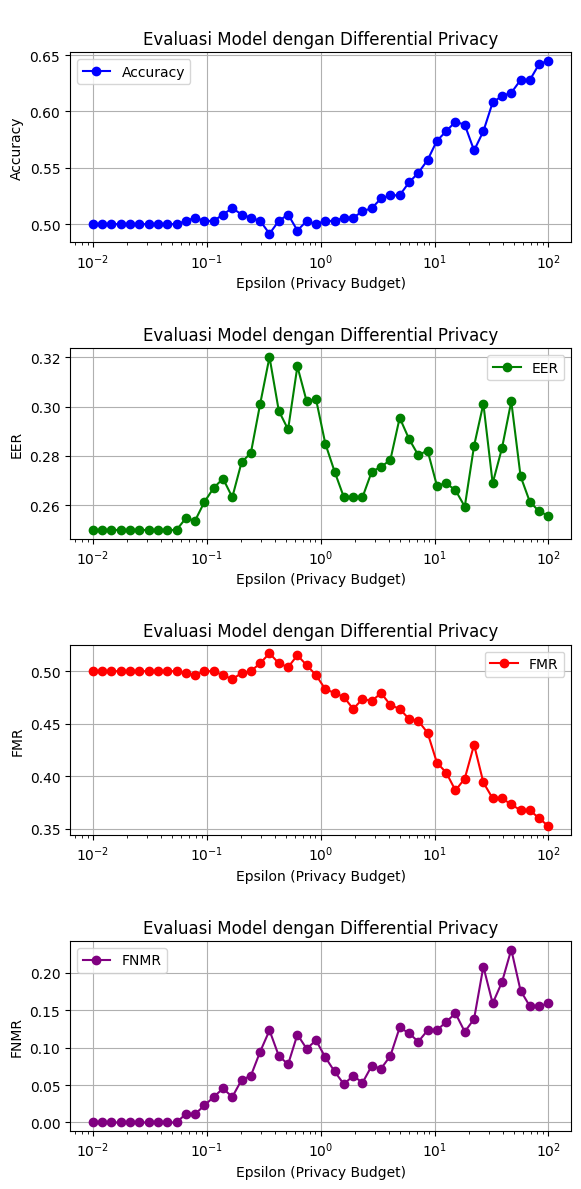

In [ ]:
# Mengatur ukuran gambar
plt.figure(figsize=(6, 12))

# Visualisasi Akurasi
plt.subplot(4, 1, 1)  # 4 baris, 1 kolom, grafik pertama
plt.semilogx(epsilon_values, accuracy_avg, label='Accuracy', color='b', marker='o')
plt.title("\nEvaluasi Model dengan Differential Privacy")
plt.xlabel("Epsilon (Privacy Budget)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Visualisasi EER
plt.subplot(4, 1, 2)  # 4 baris, 1 kolom, grafik kedua
plt.semilogx(epsilon_values, eer_avg, label='EER', color='g', marker='o')
plt.title("\nEvaluasi Model dengan Differential Privacy")
plt.xlabel("Epsilon (Privacy Budget)")
plt.ylabel("EER")
plt.legend()
plt.grid(True)

# Visualisasi FMR
plt.subplot(4, 1, 3)  # 4 baris, 1 kolom, grafik ketiga
plt.semilogx(epsilon_values, fmr_avg, label='FMR', color='r', marker='o')
plt.title("\nEvaluasi Model dengan Differential Privacy")
plt.xlabel("Epsilon (Privacy Budget)")
plt.ylabel("FMR")
plt.legend()
plt.grid(True)

# Visualisasi FNMR
plt.subplot(4, 1, 4)  # 4 baris, 1 kolom, grafik keempat
plt.semilogx(epsilon_values, fnmr_avg, label='FNMR', color='purple', marker='o')
plt.title("\nEvaluasi Model dengan Differential Privacy")
plt.xlabel("Epsilon (Privacy Budget)")
plt.ylabel("FNMR")
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.tight_layout()  # Agar subplot tidak saling bertumpukan
plt.show()


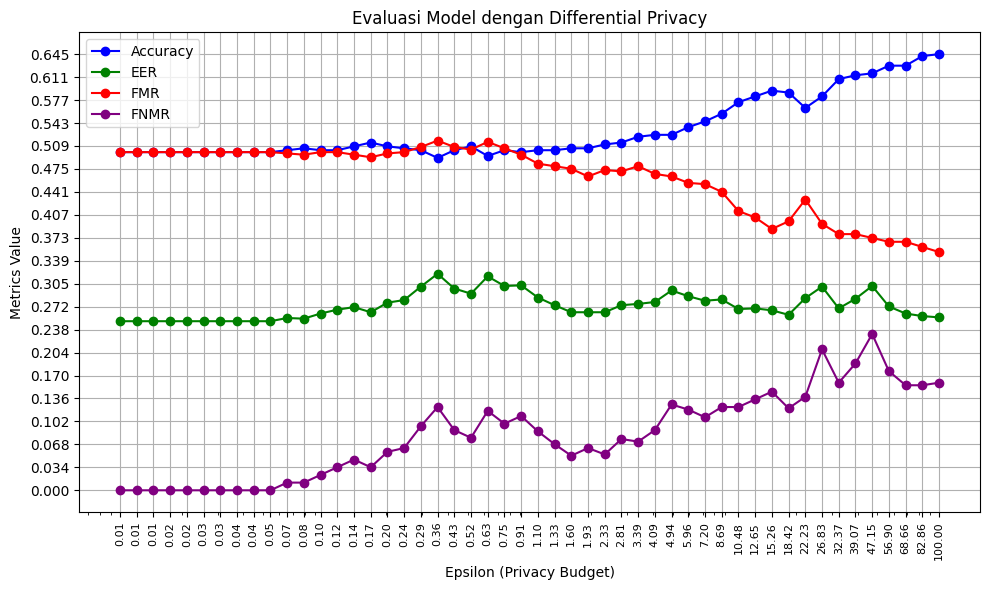

In [ ]:
plt.figure(figsize=(10, 6))

# Accuracy
plt.semilogx(epsilon_values, accuracy_avg, label='Accuracy', color='b', marker='o')

# EER
plt.semilogx(epsilon_values, eer_avg, label='EER', color='g', marker='o')

# FMR
plt.semilogx(epsilon_values, fmr_avg, label='FMR', color='r', marker='o')

# FNMR
plt.semilogx(epsilon_values, fnmr_avg, label='FNMR', color='purple', marker='o')

# Menambahkan judul, label, dan grid
plt.title("Evaluasi Model dengan Differential Privacy")
plt.xlabel("Epsilon (Privacy Budget)")
plt.ylabel("Metrics Value")
plt.legend()
plt.grid(True)

# Mengatur ticks pada sumbu y agar lebih detail
all_metrics = np.concatenate([accuracy_avg, eer_avg, fmr_avg, fnmr_avg])
y_min = min(all_metrics)
y_max = max(all_metrics)
y_ticks = np.linspace(y_min, y_max, num=20)  # Membuat 20 ticks antara nilai min dan max
plt.yticks(y_ticks, labels=[f"{val:.3f}" for val in y_ticks])

# Menampilkan semua nilai epsilon di sumbu x
plt.xticks(epsilon_values, labels=[f"{val:.2f}" for val in epsilon_values], rotation=90, fontsize=8)

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()
